In [2]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from gensim.models import Word2Vec

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
df = pd.read_csv('./input/simpsons_dataset.csv')
df.shape

(158314, 2)

In [4]:
df.head()
df.isnull().sum()
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [5]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [6]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.25 mins


In [7]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85964, 1)

In [8]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

INFO - 15:47:43: collecting all words and their counts
INFO - 15:47:43: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:47:43: PROGRESS: at sentence #10000, processed 63561 words and 52816 word types
INFO - 15:47:43: PROGRESS: at sentence #20000, processed 130943 words and 99866 word types
INFO - 15:47:44: PROGRESS: at sentence #30000, processed 192972 words and 138532 word types
INFO - 15:47:44: PROGRESS: at sentence #40000, processed 249842 words and 172659 word types
INFO - 15:47:44: PROGRESS: at sentence #50000, processed 311265 words and 208566 word types
INFO - 15:47:44: PROGRESS: at sentence #60000, processed 373588 words and 243702 word types
INFO - 15:47:45: PROGRESS: at sentence #70000, processed 436441 words and 278740 word types
INFO - 15:47:45: PROGRESS: at sentence #80000, processed 497829 words and 311886 word types
INFO - 15:47:45: collected 330804 word types from a corpus of 537160 words (unigram + bigrams) and 85964 sentences
INFO - 15:47:45: us

30178

In [9]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

In [10]:
cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

w2v_model.init_sims(replace=True)

INFO - 15:47:51: collecting all words and their counts
INFO - 15:47:51: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:47:52: PROGRESS: at sentence #10000, processed 61718 words, keeping 9558 word types
INFO - 15:47:52: PROGRESS: at sentence #20000, processed 127351 words, keeping 14506 word types
INFO - 15:47:52: PROGRESS: at sentence #30000, processed 187829 words, keeping 17619 word types
INFO - 15:47:53: PROGRESS: at sentence #40000, processed 243332 words, keeping 20385 word types
INFO - 15:47:53: PROGRESS: at sentence #50000, processed 303182 words, keeping 22878 word types
INFO - 15:47:53: PROGRESS: at sentence #60000, processed 363940 words, keeping 25200 word types
INFO - 15:47:54: PROGRESS: at sentence #70000, processed 425408 words, keeping 27401 word types
INFO - 15:47:54: PROGRESS: at sentence #80000, processed 485464 words, keeping 29275 word types
INFO - 15:47:54: collected 30178 word types from a corpus of 523700 raw words and 85964 sentence

Time to build vocab: 0.08 mins
Time to train the model: 1.36 mins


In [11]:
print(w2v_model.wv.most_similar(positive=["homer"]))


[('bongo', 0.7738182544708252), ('marge', 0.7734278440475464), ('rude', 0.7602810263633728), ('snuggle', 0.7525780200958252), ('gee', 0.7492417693138123), ('sorry', 0.7390510439872742), ('worry', 0.7367825508117676), ('wife', 0.735477864742279), ('crummy', 0.7334720492362976), ('sweetheart', 0.7308416962623596)]


In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [18]:
def tsnescatterplot(model, word, list_names, dim):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    #reduc = PCA(n_components=50).fit_transform(arrays)
    reduc = PCA(n_components=dim).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

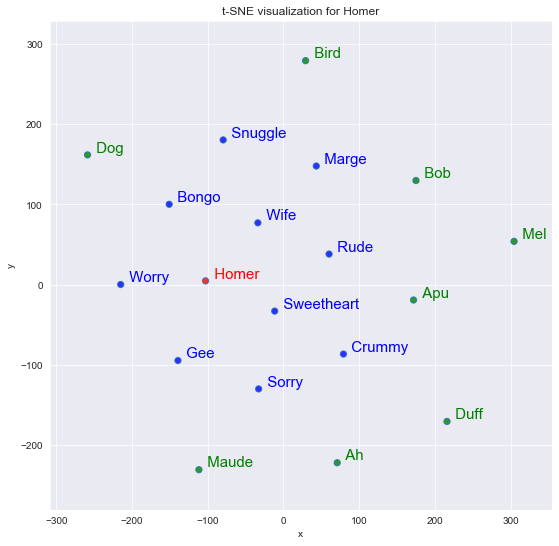

In [19]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'], 19)

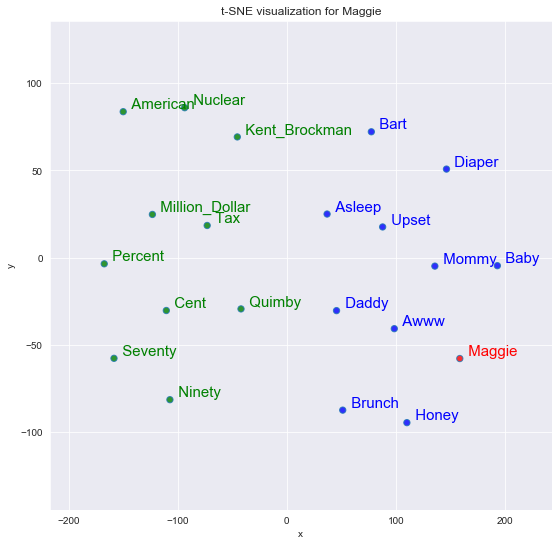

In [22]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])], 21)

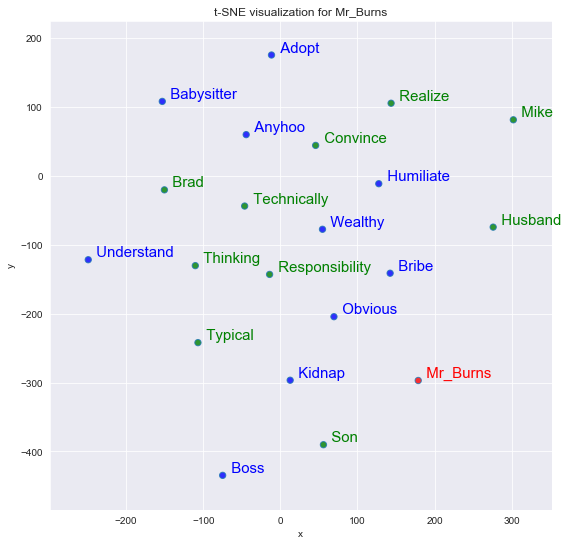

In [26]:
tsnescatterplot(w2v_model, "mr_burns", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burns"], topn=20)][10:], 21)


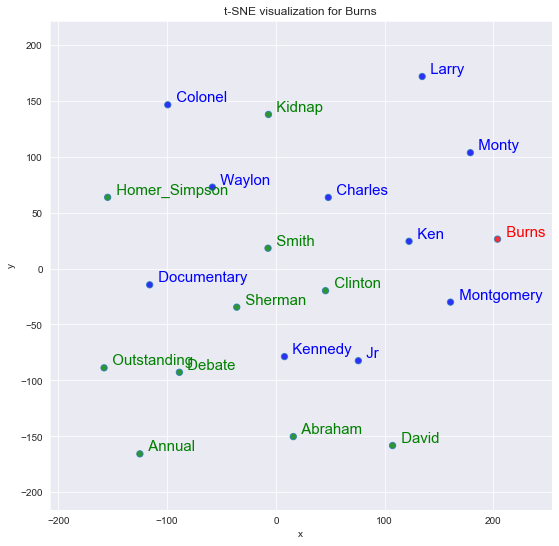

In [28]:
tsnescatterplot(w2v_model, "burns", [t[0] for t in w2v_model.wv.most_similar(positive=["burns"], topn=20)][10:], 21)
